# Background
- **Author**: `<林宜萱>`
- **Created At**: `<2025-11-08>`
- **Path to Training Data： extent-of-discount-rate-DE.csv** 
- **Path to Testing Data： extent-of-discount-rate-DE.csv** 
- **Model Specification**
    - Method： XGBoost regression
    - Variables：  
    Dependent Variable (y): DiscountRate  
    Independent Variables (X): ["Age", "AccumulatedPositiveRate", "SalePeriod", "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M", "FollowersGrowthRate1W", "FollowersGrowthRate2W", "FollowersGrowthRate1M", "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M", "DLC_since_last_discount", "Sequel_since_last_discount"]
    - Tuning Parameters：  
    random_state = 71  
    test_size = 0.2                        
    - Optimization Method：XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3, learning_rate=0.3) wuth one week data
- **Main Findings and Takeaways：**
    - In-sample `<R², RMSE>`:  
    1w(0.985, 0.023)、2w(0.952, 0.041)、1m(0.964, 0.035)
    - Out-sample `<R², RMSE>`:  
    1w(0.719, 0.095)、2w(0.690, 0.099)、1m(0.643, 0.107)
- **Future Direciton：**

In [4]:
# Load packages here
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


In [5]:
df = pd.read_csv('../data/processed/extent-of-discount-rate-DE.csv')

In [6]:
df.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,...,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.033624,-0.037584,0.000673,0.001362,0.003116,0.000053,0.000015,0.000023,0,0
1,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.022963,0.003837,0.000553,0.001087,0.002301,0.000004,0.000031,-0.000026,0,0
2,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,-0.039165,0.015256,0.001381,0.002082,0.004059,-0.000146,-0.000165,-0.000152,0,0
3,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,...,-0.033895,-0.006214,0.000790,0.001743,0.004781,0.000016,0.000014,-0.000011,0,0
4,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.044649,0.012697,0.000952,0.001814,0.003629,0.000002,-0.000022,-0.000005,0,0


### The actual modeling starts below
For the remaining blocks, make sure you have followed the guidelines as specified in [專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


In [12]:
# 定義特徵與目標 
base_features = [
    "Age", "AccumulatedPositiveRate", "SalePeriod", "DiscountFreq3M",
    "DLC_since_last_discount", "Sequel_since_last_discount"
]

feature_sets = {
    "1W": ["PlayerGrowthRate1W", "FollowersGrowthRate1W", "PositiveRateGrowthRate1W"],
    "2W": ["PlayerGrowthRate2W", "FollowersGrowthRate2W", "PositiveRateGrowthRate2W"],
    "1M": ["PlayerGrowthRate1M", "FollowersGrowthRate1M", "PositiveRateGrowthRate1M"]
}

y = df["DiscountRate"]



🔹 Training Model: 1W


<Figure size 700x500 with 0 Axes>

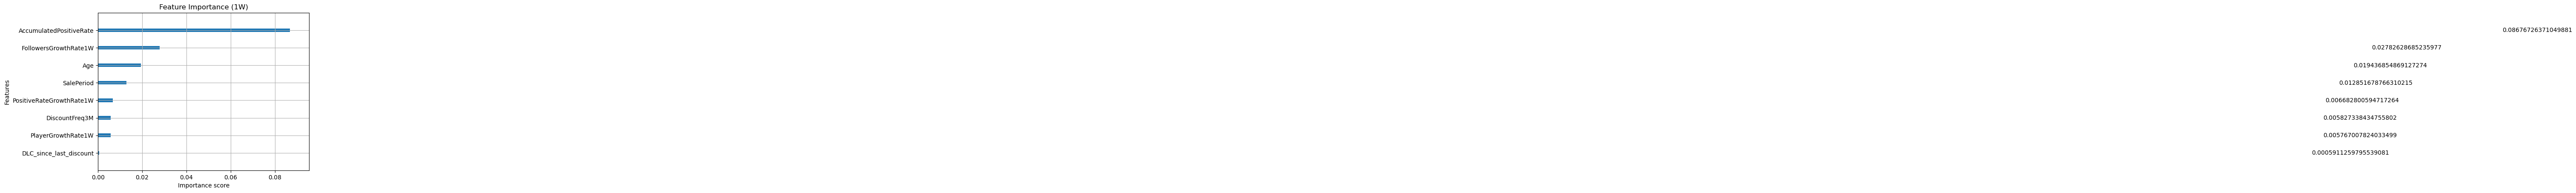


🔹 Training Model: 2W


<Figure size 700x500 with 0 Axes>

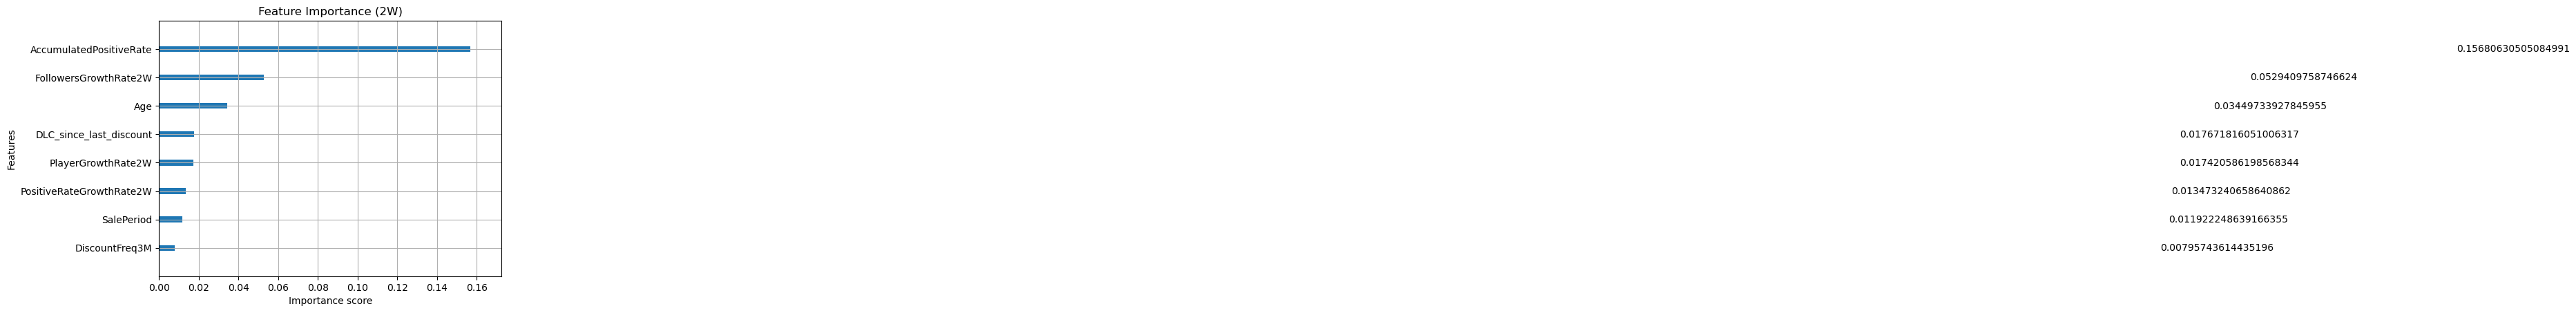


🔹 Training Model: 1M


<Figure size 700x500 with 0 Axes>

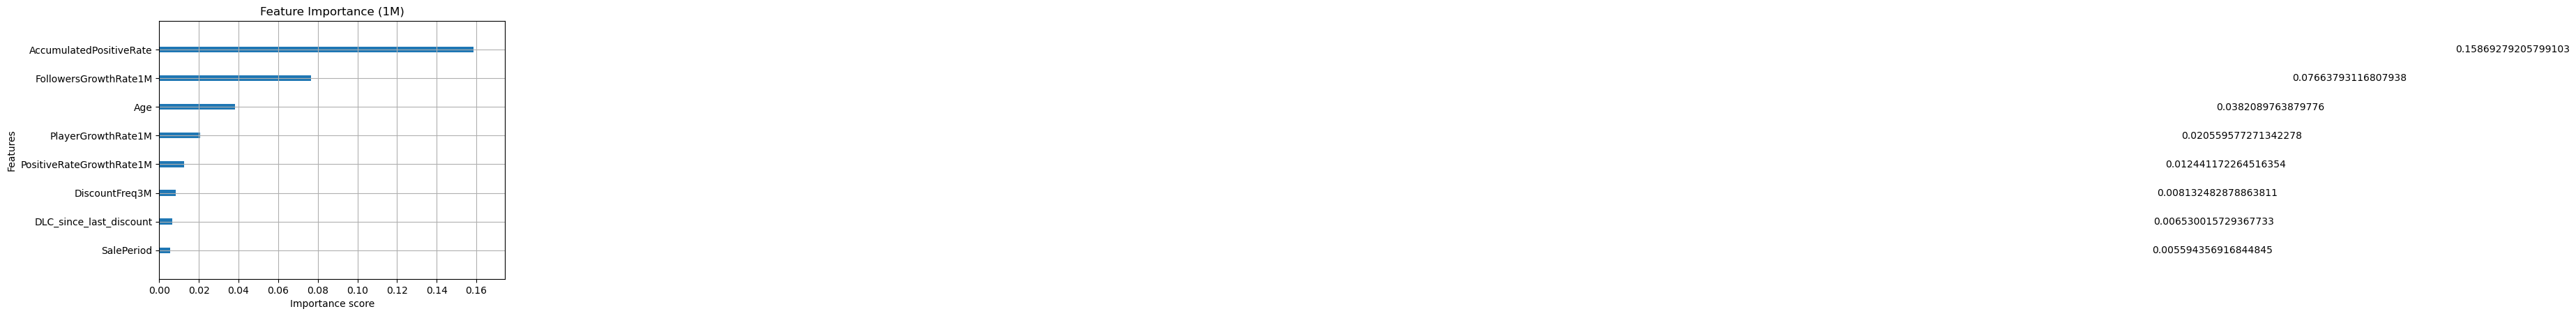


=== Model Performance Summary ===
Model                                                 Best Params  Train R²  Test R²  Train RMSE  Test RMSE
   1W {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}    0.9933   0.6139      0.0161     0.1137
   2W {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}    0.9582   0.6310      0.0401     0.1112
   1M {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}    0.9571   0.6017      0.0406     0.1155


In [13]:
# 建立 XGBoost 模型與參數網格 
xgb_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',  
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

results = []

for label, growth_features in feature_sets.items():
    print(f"\n🔹 Training Model: {label}")
    
    # 合併特徵
    X = df[base_features + growth_features]
    
    # 切分資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 建立模型
    model = XGBRegressor(random_state=42, objective='reg:squarederror')

    # Grid Search 尋找最佳參數
    grid = GridSearchCV(model, param_grid, scoring='r2', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # 預測
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # 評估
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    # 儲存結果
    results.append({
        "Model": label,
        "Best Params": grid.best_params_,
        "Train R²": round(train_r2, 4),
        "Test R²": round(test_r2, 4),
        "Train RMSE": round(train_rmse, 4),
        "Test RMSE": round(test_rmse, 4)
    })

    # 畫出特徵重要性
    plt.figure(figsize=(7, 5))
    plot_importance(best_model, importance_type='gain')
    plt.title(f"Feature Importance ({label})")
    plt.show()

# 輸出比較結果 
result_df = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
print(result_df.to_string(index=False))